# K-Hunt type attack

## Setup

Initial setup, such as importing required libraries, starting the database container, etc.

In [ ]:
# Automatically reload modules.
%load_ext autoreload
%autoreload 2

# Add project root to Python search path.
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Python imports.
import subprocess
import shutil
import math
import hashlib
import time
import random
import os

# Plotting.
import matplotlib.pyplot as plt
%matplotlib inline

# Widgets.
import ipywidgets as widgets

# Data analysis.
import numpy as np
import scipy.stats
import pandas as pd
import seaborn as sns

# Other libraries
import cxxfilt

# Import MATE framework.
from core.core import Core
from core.workspace import Workspace

from modules.caballero import Caballero as CaballeroModule
from modules.memory_buffers import MemoryBuffersModule
from modules.basic_block_profiler import BasicBlockProfilerModule
from modules.memory_instructions_profiler import MemoryInstructionsProfilerModule
from modules.lldb import LLDBDebuggerModule, lldb
from modules.data_dependencies import DataDependenciesModule
from modules.instruction_info import InstructionInfoModule
from modules.branch_profiler import BranchProfilerModule

from query_language.expressions import *
from query_language.node_matchers import *
from query_language.traversal_matchers import *
from query_language.get_query import get_query

# Load workspaces from database.
Workspace.load_from_db(Core())

# LLDB module
lldb_module = LLDBDebuggerModule()
lldb_module.run()

## Configuration

In [ ]:
@widgets.interact(
    run_caballero = widgets.Checkbox(value = True, description = 'Run Caballero'),
    run_basic_block_profiler = widgets.Checkbox(value = True, description = 'Run Basic Block Profiler'),
    run_memory_instructions_profiler = widgets.Checkbox(value = True, description = 'Run Memory Instructions Profiler'),
    run_data_dependencies = widgets.Checkbox(value = True, description = 'Run Data Dependencies'),
    use_data_dependencies_shortcuts = widgets.Checkbox(value = False, description = 'Use shortcut dependencies'),
    run_instruction_info = widgets.Checkbox(value = True, description = 'Run Instruction Info'),
    run_branch_profiler = widgets.Checkbox(value = True, description = 'Run Branch Profiler')
)

def update_configuration(**kwargs):
    global CFG
    CFG = kwargs

## Benchmarks

This section runs the benchmarks, and saves all collected data to the database.

### 7-Zip

7-Zip is a file archiver that also supports encryption. As a benchmark, we use the following `7za` call:

```bash
7za -mmt1 -psecret a test.7z test.pdf
```

The `-mmt` option sets the maximum number of CPU threads to `1`, and the `-p` option  sets the password to use for encryption to `secret`.

In [ ]:
sizes_kb = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

In [ ]:
def remove_output_file():
    # We need to remove the output file before every run,
    # otherwise 7-Zip will just exit.
    workspace = Workspace.current
    archive_path = os.path.join(workspace.path, 'test.7z')
    
    if os.path.isfile(archive_path):
        os.remove(archive_path)
    
def create_input_file(name, size_in_bytes):
    random.seed(0)
    
    # NOTE: We need to write random data to ensure that the compressed size
    # scales linearly with this size of the input file.
    with open(name, 'wb') as f:
        f.write(os.urandom(size_in_bytes))

def run_sevenzip_demo():
    executable_path = Core().get_subdirectory('demos', 'sevenzip', '7za')

    Workspace.create_new('szip', executable_path)
    Workspace.select('szip')
    workspace = Workspace.current

    pdf_path = Core().get_subdirectory('demos', 'sevenzip', 'test.pdf')
    shutil.copyfile(pdf_path, os.path.join(workspace.path, 'test.pdf'))

    def get_binary_params(input_file, perform_encryption = True):
        if perform_encryption:
            return f'-mmt1 -psecret a test.7z {input_file}'
        else:
            return f'-mmt1 a test.7z {input_file}'

    # Create input files of different sizes
    for size_kb in sizes_kb:
        size_in_bytes = size_kb * 1000
        input_path = os.path.join(workspace.path, f'input_{size_in_bytes}')
        create_input_file(input_path, size_in_bytes)
        
    sizes = [size_kb * 1000 for size_kb in sizes_kb]
        
    # Create pinballs
    traces = {}
    
    # Run the application with encryption, for different inputs
    for size in sizes:
        remove_output_file()
        binary_params = get_binary_params(f'input_{size}')
        recorder = Workspace.current.create_recorder(binary_params, pinball_suffix=f'input_{size}')
        traces[f'input_{size}'] = recorder
        %time recorder.run()

    # Run the application once more, with the smallest input but with encryption disabled
    remove_output_file()
    binary_params = get_binary_params(f'input_{sizes[0]}', perform_encryption = False)
    recorder = Workspace.current.create_recorder(binary_params, pinball_suffix=f'input_{sizes[0]}_noenc')
    traces[f'input_{sizes[0]}_noenc'] = recorder
    %time recorder.run()

    # (1) Caballero
    if CFG['run_caballero']:
        caballero = CaballeroModule(ratio=0.3, binary_params='', timeout=0, recorder=traces[f'input_{sizes[0]}'])
        %time caballero.run()

    for size in sizes:
        # (2) Basic block profiler
        if CFG['run_basic_block_profiler']:
            bbl_profiler = BasicBlockProfilerModule(binary_params='', timeout=0, properties_prefix=f'input_{size}_', recorder=traces[f'input_{size}'])
            %time bbl_profiler.run()

        # (3) Memory instructions profiler
        if CFG['run_memory_instructions_profiler']:
            mem_ins_profiler = MemoryInstructionsProfilerModule(binary_params='', timeout=0, properties_prefix=f'input_{size}_', recorder=traces[f'input_{size}'])
            %time mem_ins_profiler.run()

    # run basic block profiler once more, but without enabling encryption in 7-Zip this time
    if CFG['run_basic_block_profiler']:
        bbl_profiler = BasicBlockProfilerModule(binary_params='', timeout=0, properties_prefix=f'input_{sizes[0]}_noenc_', recorder=traces[f'input_{sizes[0]}_noenc'])
        %time bbl_profiler.run()

    # (4) Data dependencies
    if CFG['run_data_dependencies']:
        data_deps = DataDependenciesModule(binary_params='', timeout=0, shortcuts = CFG['use_data_dependencies_shortcuts'], recorder=traces[f'input_{sizes[0]}'])
        %time data_deps.run()

    # (5) Instruction info
    if CFG['run_instruction_info']:
        instr_info = InstructionInfoModule(binary_params='', timeout=0, recorder=traces[f'input_{sizes[0]}'])
        %time instr_info.run()
        
    # (6) Branch profiler
    if CFG['run_branch_profiler']:
        branch_profiler = BranchProfilerModule(binary_params='', timeout=0, recorder=traces[f'input_{sizes[0]}'])
        %time branch_profiler.run()

%time run_sevenzip_demo()

## Overview of K-Hunt

### Introduction

This notebook imitates the approach of K-Hunt to find cryptographic code in executables.

K-Hunt is described in the 2018 paper "K-Hunt: Pinpointing Insecure Cryptographic Keys from Execution Traces" by Li et al.

K-Hunt uses a dynamic binary analysis consisting of three Pin plugins that can be used to locate cryptographic code and keys in binary programs, and to detect insecure use of such keys.

The original repository is hosted on [GitHub](https://github.com/GoSSIP-SJTU/k-hunt).

According to the authors, K-Hunt can locate keys in symmetric ciphers, asymmetric ciphers, stream ciphers, and digital signatures, in both standard and proprietary algorithms.

## Overview of the approach

K-Hunt consists of two phases: pinpointing the cryptographic key (described in Section 4.1 of the paper) and detecting insecure use of keys (described in Section 4.2 of the paper).

The former requires a lightweight dynamic binary analysis, whereas the second involves a more heavyweight dynamic binary analysis.

### Phase I: Pinpointing cryptographic keys

This phase is split in two steps: locating the basic blocks related to crypto, and locating the crypto keys used by those basic blocks.

Each step uses different properties of crypto code and buffers to differentiate them from non-crypto code and buffers.

1. Identify cryptographic basic blocks
    - High ratio of arithmetic, bitwise, or AES instructions
    - Number of executions of the basic block is proportional to the input size
    - Data consumed and/or produced has high randomness

K-Hunt starts with the set of all basic blocks in the application, and iteratively removes basic blocks that do not satisfy one of these three conditions.

K-Hunt can also optionally use differential testing by comparing two execution traces: one where the program was run with an input that triggers the crypto operations, and one where the program was run with an input that does not trigger the crypto operations.
For example, one can run 7-Zip with and without file encryption enabled.
Basic blocks that do not appear in the execution with crypto operations, or basic blocks that occur in both executions, are removed from the set of candidate basic blocks.

2. Identify cryptographic keys from the cryptographic basic blocks
    - First, examine the data accessed by the cryptographic basic blocks
    - These basic blocks act on two types of data: the crypto key, and something else (cyphertext in the case of decryption, plaintext for encryption, message for signing, ...)
    - We need to differentiate between these two, which K-Hunt does based on:
        - Size: key buffers are smaller, and their size is constant w.r.t. the input size
        - Data source: key buffers have a different data source (Random Number Generator) than the other buffers (file, network, ...)

### Phase II: Detecting insecure keys

K-Hunt detects three types of insecurely used keys:
1. Deterministically generated keys: keys generated from a source without enough entropy
2. Insecurely negotiated keys: a shared key where one party can generate a key without involving the other party
3. Recoverable key: keys that are kept in memory for an inordinate amount of time

In this phase, insecure usage of keys is detected using dynamic taint analysis at the function level:

1. Check the origin of the key (to detect deterministically generated keys and insecurely negotiated keys)
2. Check the propagation of the key (to detect improperly cleaned up key)

## Experiment

### 7-zip

#### Finding cryptographic code

In [ ]:
Workspace.select('szip')
db = Workspace.current.graph

Let's first see how many basic blocks were recorded by our Pin plugins.

In [ ]:
print(db.run_evaluate('''
             MATCH (bbl:BasicBlock)
             RETURN COUNT(*)
             '''))

First, let's select all basic blocks that are detected by the Caballero heuristic.

In [ ]:
data = db.run_list('''
              MATCH (bbl:BasicBlock)
              WHERE bbl.caballero = True
              RETURN bbl
              ''')

print(f"Found {len(data)} basic block(s) annotated by Caballero.")

Let's see how many times the AES basic block is executed for different input sizes.

In [ ]:
def plot_num_executions(entry):
    x_labels = np.array([1000 * size_kb for size_kb in sizes_kb])
    y_labels = np.array([entry['bbl'][f'input_{x}_num_executions'] for x in x_labels])
    
    plt.title('Number of executions of AES basic block i.f.o. input size')
    plt.xlabel('Input size [bytes]')
    plt.ylabel('Number of executions')
    plt.xscale('log')
    plt.yscale('log')
    plt.plot(x_labels, y_labels, 'o-')

for entry in data:
    if entry['bbl']['image_name'] == '7za' and entry['bbl']['image_offset_begin'] in [0xad84]:
        plot_num_executions(entry)

Next, let's look at the subset of those basic blocks of which the number of executions scales linearly with the input size.

In [ ]:
def calculate_rsquared(entry):
    x_labels = np.array([1000 * size_kb for size_kb in sizes_kb])
    y_labels = np.array([entry['bbl'][f'input_{x}_num_executions'] for x in x_labels])
    
    # Remove entries with None
    mask = y_labels != None
    
    x_labels = x_labels[mask]
    y_labels = y_labels[mask]
        
    # Calculate linear regression    
    res = scipy.stats.linregress(x_labels.astype(float), y_labels.astype(float))
    
    # Return R^2 value
    return res.rvalue ** 2

def plot_rsquared_distribution():
    x = [calculate_rsquared(entry) for entry in data]
    
    plt.title('Distribution of $R^2$ values of num_executions i.f.o. input size')
    plt.xlabel("Pearson's correlation coefficient ($R^2$)")
    plt.ylabel('Absolute frequency')
    plt.hist(x, bins=20)
    
plot_rsquared_distribution()

Let's remove all basic blocks that have an $R^2$ lower than $0.8$.

In [ ]:
data_1 = [entry for entry in data if calculate_rsquared(entry) > 0.8]

print(f'Reduced set from {len(data)} to {len(data_1)} basic block(s)')

We can see that around 70% of the basic blocks are filtered out by this heuristic.

The basic blocks we are interested in (`0xad84 -> 0xae7b` and `0xae7b -> 0xaf73`) are still part of this subset.

In [ ]:
for entry in data_1:
    if entry['bbl']['image_name'] == '7za' and entry['bbl']['image_offset_begin'] in [0xad84, 0xae7b]:
        print(entry)
        print(hex(entry['bbl']['image_offset_begin']))
        print(hex(entry['bbl']['image_offset_end']))
        print('-' * 100)

Where do the other basic blocks come from?

In [ ]:
def print_routine_names():
    routines = [entry['bbl']['routine_name'] for entry in data_1]
    
    from collections import Counter
    
    counts = Counter(routines).most_common()
    
    for item in counts:
        print(f'{item[1]} {item[0]:30}')

print_routine_names()

These basic blocks fall in the following categories:
- Related to AES encryption
- Related to LZMA compression
- Related to CRC error detection
- The `get_pc_thunk` for some reason???

Can we filter these further with the entropy of read/written values, as K-Hunt does?

Let's define a function that evaluates how "random" a basic block is, based on the byte-Shannon entropy of the values read/written by its instructions.

In [ ]:
def basic_block_randomness(bbl):
    # Obtain the list of instructions that are part of this basic block.
    insns = db.run_list(get_query(
        Instruction(
            P('image_name') == bbl['image_name'],
            P('image_offset') >= bbl['image_offset_begin'],
            P('image_offset') < bbl['image_offset_end']
        ).bind('ins')
    ))
    
    # Get the prefixes for all different inputs.
    input_sizes = np.array([1000 * size_kb for size_kb in sizes_kb])
    
    randomness = 0
    
    # Get a randomness score for each instruction, and take the maximum of all instruction randomnesses to get the randomness of the basic block.
    for ins in insns:
        for input_size in input_sizes:
            randomness = max(randomness, ins['ins'][f'input_{input_size}_read_values_entropy'] or 0.0)
            randomness = max(randomness, ins['ins'][f'input_{input_size}_written_values_entropy'] or 0.0)
            
    return randomness

print(f'{"Offset range":26} {"Routine name":30} {"Randomness of data produced/consumed"}')
print('=' * 94)
for entry in sorted(data_1, key=lambda entry: entry['bbl']['image_offset_begin']):
    print(f"{hex(entry['bbl']['image_offset_begin']):8} -> {hex(entry['bbl']['image_offset_end']):15}"
          f"{entry['bbl']['routine_name']:30} {basic_block_randomness(entry['bbl'])}")

Let's filter out all basic blocks which have randomness < 0.9:

In [ ]:
data_2 = [entry for entry in data_1 if basic_block_randomness(entry['bbl']) >= 0.9]

print(f'{len(data_2)} out of {len(data_1)} basic blocks left with high randomness.')

We can also use the differential analysis of K-Hunt: run 7-Zip with and without encryption, and only consider basic blocks that are executed when encryption is on but not when encryption is off.

In [ ]:
for entry in sorted(data_2, key=lambda x: x['bbl']['image_offset_begin']):
    num_executions_crypto = entry['bbl']['input_1000_num_executions'] or 0
    num_executions_non_crypto = entry['bbl']['input_1000_noenc_num_executions'] or 0

    if num_executions_crypto > 0 and num_executions_non_crypto == 0:
        print(f"{hex(entry['bbl']['image_offset_begin'])} -> {hex(entry['bbl']['image_offset_end']):15}"
              f"{entry['bbl']['routine_name']:20} {num_executions_crypto:4} {num_executions_non_crypto:4}")

We thus found the basic blocks implementing the AES encryption!

#### Finding cryptographic key

Now let's find the key starting from those crypto basic blocks.

We start with all instructions that read from memory and that occur in these basic blocks.

In [ ]:
insns = db.run_list(get_query(
    Instruction(
        P('image_offset') >= 0xad46,
        P('image_offset') < 0xb0d1,
        P('input_1000_num_unique_byte_addresses_read') > 0
    ).bind('ins')
))

K-Hunt's first criterion to locate keys is based on the size of memory buffers, i.e. the number of distinct byte addresses that an instruction reads.

Because the key is typically relatively small, we can look for instructions that read from a limited number of byte addresses.

In [ ]:
def plot_num_unique_byte_addresses_distribution():
    size = 1000
    
    x = [entry['ins'][f'input_{size}_num_unique_byte_addresses_read'] for entry in insns]
    
    plt.title('Distribution of num_unique_byte_addresses_read')
    plt.xlabel(f"input_{size}_num_unique_byte_addresses_read")
    plt.ylabel('Absolute frequency')
    plt.hist(x, bins=30)
    
plot_num_unique_byte_addresses_distribution()

Unfortunately, most instructions read from a relative limited set of addresses.

Another way in which we can find the key is to look at the variance of the number of unique addresses read from over different input sizes.

Because the key is of fixed length, we expect this variance to be close to $0$ for the instruction that reads the key.

In [ ]:
def calculate_standard_deviation(entry):
    x_labels = np.array([1000 * size_kb for size_kb in sizes_kb])
    y_labels = np.array([entry['ins'][f'input_{x}_num_unique_byte_addresses_read'] for x in x_labels])
        
    # Remove entries with None
    mask = y_labels != None
    
    x_labels = x_labels[mask]
    y_labels = y_labels[mask]
        
    # Calculate standard deviation
    return np.std(y_labels.astype(float))

def plot_std_distribution():
    x = [calculate_standard_deviation(entry) for entry in insns]
    
    plt.title('Distribution of $\sigma$ values of num_unique_byte_addresses_read')
    plt.xlabel("Standard deviation of num_unique_byte_addresses_read ($\sigma$)")
    plt.ylabel('Absolute frequency')
    plt.hist(x, bins=20)
    
plot_std_distribution()

Unfortunately, both heuristics include the instructions that read the key, and instructions that read the input.

This is because 7-Zip uses AES in a CBC scheme:

<div>
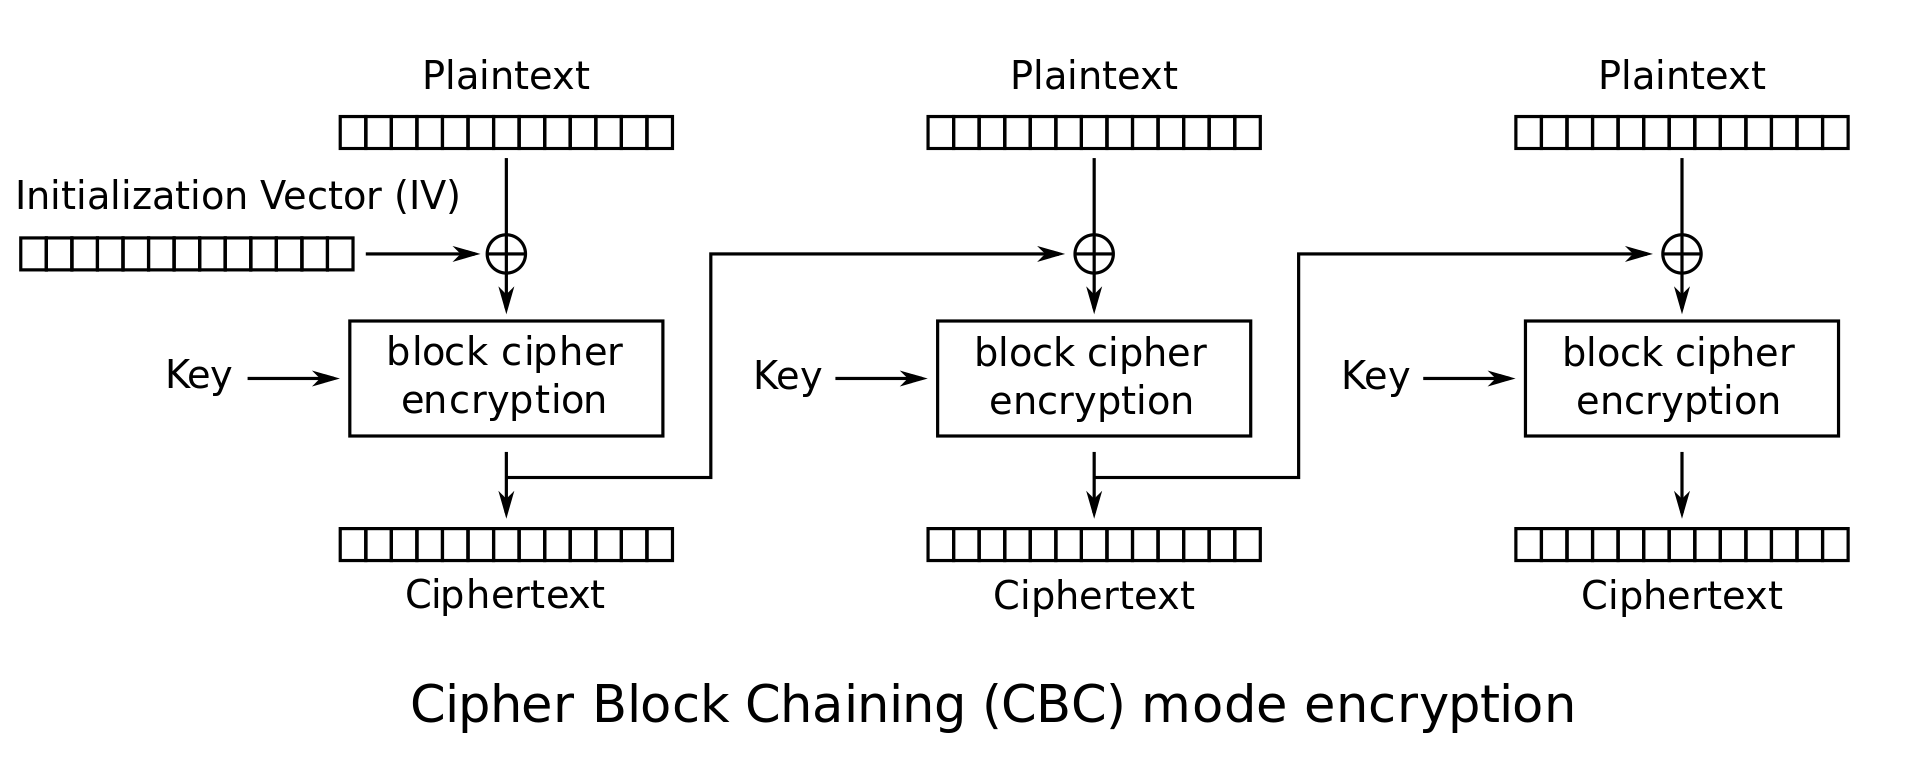
</div>

The input to the cryptographic basic blocks is $\text{plaintext}_{i} \oplus \text{ciphertext}_{i-1}$, which is precalculated and stored in the same buffer in each iteration.

As such, the number of addresses read by the instructions that read the input is also constant w.r.t. to the input size.

We can also try a differential analysis: run 7-Zip with different inputs, and record the values read by each instruction.

Because the key is constant, we can find it by looking at instructions that always read the same value.

In [ ]:
for entry in insns:
    if len(set(entry['ins'][f'input_{size_kb * 1000}_read_values'] for size_kb in sizes_kb)) == 1:
        print(hex(entry['ins']['image_offset']), set(entry['ins'][f'input_{size_kb * 1000}_read_values'] for size_kb in sizes_kb))

Let's start with the first of these instructions at `0xad52`, and look at the contents of the buffer its memory operand points to.

We will do so by running 7-Zip in the debugger LLDB and setting a breakpoint at that location.

In [ ]:
# Copy the input PDF file to the debugger container
lldb_module.upload_file(os.path.join(Workspace.current.path, 'test.pdf'), 'test.pdf')

# Remove the test.7z file, if it exists already
lldb_module.run_shell_command('rm test.7z')

# Create a target for 7-Zip
target = lldb_module.debugger.CreateTarget(os.path.join(Workspace.current.path, '7za'))
assert(target)

# Set a breakpoint at 0xad52
bp_addr = lldb_module.resolve_address(target, '7za', 0xad52)
bp = target.BreakpointCreateBySBAddress(bp_addr)
print(bp)

# Run the application, stopping at that instruction
process = target.LaunchSimple(['-mmt1', '-psecret', 'a', 'test.7z', 'test.pdf'], None, None)
try:
    # Print the instruction opcode corresponding to the breakpoint
    assert(process)
    print(process)
    
    assert(process.GetState() == lldb.eStateStopped)
    
    thread = process.GetSelectedThread()
    assert(thread)
    print(thread)
    
    frame = thread.GetFrameAtIndex(0)
    assert(frame)
    print(frame)
    
    instructions = target.ReadInstructions(frame.GetPCAddress(), 1)
    for ins in instructions:
        print(ins)
        
    # Print the value of %eax for that instruction (i.e. the address of the buffer)
    memory_operand = int(frame.FindRegister('eax').GetValue(), 16)
    print('eax =', hex(memory_operand))
    buffer_address = lldb.SBAddress(memory_operand, target)
    
    # Read the memory contents of the buffer
    err = lldb.SBError()
    buffer_contents = target.ReadMemory(buffer_address, 240, err)
    assert(err.Success())
    
    # Pretty print the buffer contents
    print('Buffer contents:')
    i = 0
    for byte in buffer_contents:
        print(format(byte, '02x'), end=' ')
        i = i + 1
        
        if i % 16 == 0:
            print()
finally:
    # Kill process. This is necessary to restart it later.
    process.Kill()

We can see that these values correspond to the values read by the other instructions that we found.

For example, `0xad5a` reads `65 11 f1 50`, `0xad64` reads `7a 3c 2a 98`, `0xad6a` reads `2a e6 de f4`, `0xad70` reads `f6 58 18 ed`, and so on.

If the attacker knows that the cryptographic code implement an AES-256 symmetric cipher, he can make the assumption that the contents of this buffer are the round keys.

For AES, each round key is 16 bytes (128 bits) long, and is calculated from the key using the AES key schedule:

$$
W_i =
\begin{cases}
    K_i & \text{if } i < N \\
    W_{i-N} \oplus \text{SubWord}(\text{RotWord}(W_{i-1})) \oplus \text{rcon}_{i / N} & \text{if } i \geq N \text{ and } i \equiv 0 \pmod{N} \\
    W_{i-N} \oplus \text{SubWord}(W_{i-1}) & \text{if } i \geq N > 6 \text{ and } i \equiv 4 \pmod{N} \\
    W_{i-N} \oplus W_{i-1} & \text{otherwise}
\end{cases}
$$

where $W_i$ is the $i$th 32-bit word of the expanded key, $K_i$ is the $i$th 32-bit word of the original key, and $N$ is the length of the key.

In other words, the first 32 bytes of the buffer contents after `0x07 00 .. 00` above are precisely the AES key we are looking for:
```
AES key =
        65 11 f1 50 7a 3c 2a 98 2a e6 de f4 f6 58 18 ed
        6c f2 42 65 1a ca 19 d1 5c eb c6 a6 7a e2 89 1d
```

In [ ]:
print('AES Key:')
for byte in buffer_contents[16:48]:
    print(format(byte, '02x'), end=' ')

To verify whether we have found the right key, we add the following excerpt to the end of `CKeyInfo::CalcKey()` in `CPP/7zip/Crypto/7zAes.cpp`, which implements the KDF:

```cpp
  std::cout << "KEY: ";
  for (unsigned int i = 0; i < kKeySize; ++i) {
      std::cout << std::hex << (int)Key[i] << ' ';
  }
  std::cout << std::endl;
```

which prints the following to stdout:

```
KEY: 65 11 f1 50 7a 3c 2a 98 2a e6 de f4 f6 58 18 ed 6c f2 42 65 1a ca 19 d1 5c eb c6 a6 7a e2 89 1d 
```

This means we succeeded in finding the crypto key.

**TODO:** Find key using second heuristic in K-Hunt: follow data dependencies. Key comes from `argv` in the case of 7-Zip, input comes from file.

#### Data dependency graph

##### Create GDS graph

In [ ]:
# Create GDS graph.
if db.run_evaluate('''CALL gds.graph.exists('data_dependencies') YIELD exists'''):
    db.run('''
           CALL gds.graph.drop('data_dependencies')
           ''')

db.run('''
       CALL gds.graph.project.cypher(
           // Graph name
           'data_dependencies',
           
           // Node query
           'MATCH (n:Instruction)
            RETURN id(n) AS id',
           
           // Relationship query
           'MATCH (n:Instruction) -[r:DEPENDS_ON]-> (m:Instruction)
            WHERE (r.register IS NULL) OR (NOT r.register IN $blacklisted_regs)
            RETURN id(n) AS source, id(m) AS target',
            
            // Parameters
            {
                parameters: { blacklisted_regs: ["rsp", "esp", "rip", "eip"] }
            }
        )
       ''')

##### Dijkstra single-source (shortest paths)

In [ ]:
# Find dependencies of some instructions in the AES basic blocks:
# - 0xad5a: reads the AES key
# - 0xad52: reads the round trip count
# - 0xae51: reads something that varies for every execution (input?)

dependent_instructions = {offset: db.run_list(f'''
MATCH (source:Instruction {{image_name: '7za', image_offset: {offset}}})
CALL gds.allShortestPaths.dijkstra.stream('data_dependencies', {{
    sourceNode: id(source)
}})
YIELD index, sourceNode, targetNode, totalCost, nodeIds, costs, path
RETURN *
''') for offset in [0xad5a, 0xad52, 0xae51]}

In [ ]:
# Get the node IDs of instructions in the KDF function (NCrypto::N7z::CKeyInfo::CalcKey())
kdf_node_keys = {entry['id']: entry['image_offset'] 
 for entry in 
 db.run_list('''
        MATCH (n:Instruction)
        WHERE n.image_name = "7za"
        AND 0xb27aa <= n.image_offset <= 0xb2a29
        RETURN id(n) AS id, n.image_offset AS image_offset
        ''')
}

In [ ]:
def pretty_print_path(ins):
    nodeIds = ins['nodeIds']
    for i, nodeId in enumerate(nodeIds):
        node = db.run_evaluate(f'''
                      MATCH (n)
                      WHERE id(n) = {nodeId}
                      RETURN (n)
                      ''')
        
        
        print(
              f'''{i:2}: {node['image_name']}+{hex(node['image_offset']):10}'''
              f''' {node['opcode']:8} {node['operands']:35}'''
              f''' {cxxfilt.demangle(node['routine_name']):75}'''
              f''' {os.path.abspath(node['DEBUG_filename'] or '/')}:{node['DEBUG_line']}:{node['DEBUG_column']}'''
        )

for key in dependent_instructions.keys():
    for ins in dependent_instructions[key]:
        target_id = ins['targetNode']
        cost = ins['totalCost']
        
        if target_id in kdf_node_keys.keys():
            offset = kdf_node_keys[target_id]
            print(f'Found path of cost {cost} from {hex(key)} to {hex(offset)} (in KDF)')
            pretty_print_path(ins)
            print()
            
    print('-' * 200)

##### Breadth first search

In [ ]:
# - using same filtered graph as before (dependencies through %rsp and %rip ignored)
# - start at a given node
# - terminate when either a given node is reached, or when a given max depth is reached
# - returns all visited nodes, in the order that they are visited

for entry in db.run_list('''
       MATCH (source:Instruction {image_name: '7za', image_offset: 0xad5a})
       CALL gds.bfs.stream('data_dependencies', {
           sourceNode: id(source),
           maxDepth: 2
       })
       YIELD path
       UNWIND [ n in nodes(path) ] AS node
       RETURN node.image_name, node.image_offset
       '''):
    print(entry)

In [ ]:
# number of nodes that need to be visited = rank of node
for i, entry in enumerate(db.run_list('''
       MATCH (source:Instruction {image_name: '7za', image_offset: 0xad5a})
       CALL gds.bfs.stream('data_dependencies', {
           sourceNode: id(source),
           maxDepth: 2
       })
       YIELD path
       UNWIND [ n in nodes(path) ] AS node
       RETURN node.image_name, node.image_offset
       ''')):
    print(f'{entry} requires analysis of {i+1} node(s).')

In [ ]:
# by adding an attribute to each node containing its "analysis cost", we can
# also estimate the total analysis effort required by an attacker.
cumulative_cost = 0
for i, entry in enumerate(db.run_list('''
       MATCH (source:Instruction {image_name: '7za', image_offset: 0xad5a})
       CALL gds.bfs.stream('data_dependencies', {
           sourceNode: id(source),
           maxDepth: 2
       })
       YIELD path
       UNWIND [ n in nodes(path) ] AS node
       RETURN node.image_name, node.image_offset, size(node.operands) AS analysis_cost
       ''')):
    cumulative_cost += entry['analysis_cost']
    print(f'{entry} requires analysis of {i+1} node(s) with total cost {cumulative_cost}.')

In [ ]:
# of course, this assumes a certain ordering of nodes.
# ideally, we want to get average costs, under the assumption that we visit nodes at the same depth in a random order.
# for this, we need the depth of each node, which is not returned by GDS's BFS, but is easy enough to find using Cypher in this case
# (though this is not perfect, as it doesn't use the same graph with %rsp and %rip filtered, but rather the original database graph...)
for i, entry in enumerate(db.run_list('''
       MATCH (source:Instruction {image_name: '7za', image_offset: 0xad5a})
       CALL gds.bfs.stream('data_dependencies', {
           sourceNode: id(source),
           maxDepth: 2
       })
       YIELD path
       UNWIND [ n in nodes(path) ] AS node
       RETURN node.image_name, node.image_offset, 
              CASE id(source)
                  WHEN id(node) THEN 0
                  ELSE length(shortestPath((source)-[:DEPENDS_ON*..2]->(node)))
              END AS distance
       ''')):
    print(f'{entry} requires analysis of {i+1} node(s).')

In [ ]:
# now we can print the average number of nodes that need to be visited (see num_nodes)
data = db.run_list('''
       MATCH (source:Instruction {image_name: '7za', image_offset: 0xad5a})
       CALL gds.bfs.stream('data_dependencies', {
           sourceNode: id(source),
           maxDepth: 2
       })
       YIELD path
       UNWIND [ n in nodes(path) ] AS node
       RETURN node.image_name, node.image_offset, 
              CASE id(source)
                  WHEN id(node) THEN 0
                  ELSE length(shortestPath((source)-[:DEPENDS_ON*..2]->(node)))
              END AS distance
       ''')
    
_, distance_counters = np.unique([entry['distance'] for entry in data], return_counts = True)
cumulative_distance_counters = np.cumsum(distance_counters)
    
print(f'distance_counters: {distance_counters}')
print(f'cumulative_distance_counters: {cumulative_distance_counters}')
print()

for i, entry in enumerate(data):
    dist = entry['distance']
    # all nodes of < distance + Unif(1, number of nodes of = distance)
    num_nodes = (cumulative_distance_counters[dist-1] if dist != 0 else 0) + (1 + distance_counters[dist]) / 2
    print(f'{entry} requires analysis of {num_nodes} node(s) on average.')

In [ ]:
# we can do something similar with average analysis cost (see avg_cost)
data = db.run_list('''
       MATCH (source:Instruction {image_name: '7za', image_offset: 0xad5a})
       CALL gds.bfs.stream('data_dependencies', {
           sourceNode: id(source),
           maxDepth: 2
       })
       YIELD path
       UNWIND [ n in nodes(path) ] AS node
       RETURN node.image_name, node.image_offset, size(node.operands) AS analysis_cost,
              CASE id(source)
                  WHEN id(node) THEN 0
                  ELSE length(shortestPath((source)-[:DEPENDS_ON*..2]->(node)))
              END AS distance
       ''')
    
total_cost_counters = [0] * 3

for entry in data:
    dist = entry['distance']
    cost = entry['analysis_cost']
    total_cost_counters[dist] += cost

cumulative_total_cost_counters = np.cumsum(total_cost_counters)
    
print(f'total_cost_counters: {total_cost_counters}')
print(f'cumulative_total_cost_counters: {cumulative_total_cost_counters}')
print()

for i, entry in enumerate(data):
    dist = entry['distance']
    cost = entry['analysis_cost']
    # all nodes of < distance + node itself + 1/2 * other nodes of = distance
    avg_cost = (cumulative_total_cost_counters[dist-1] if dist != 0 else 0) + cost + 1/2 * (total_cost_counters[dist] - cost)
    print(f'{entry} requires analysis of a total cost of {avg_cost} on average.')